<a href="https://colab.research.google.com/github/lala991204/ML-self-study/blob/master/4_6_XGBoost(eXtra_Gradient_Boost).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

XGBoost 버전 확인

In [ ]:
import xgboost

print(xgboost.__version__)

0.90


# 파이썬 Native XGBoost 적용 - 위스콘신 Breast Cancer 데이터셋

In [ ]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [ ]:
print(dataset.target_names)     # 각각 1, 0 value들이 뜻하는 바 (악의있는, 온화한)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [ ]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                    test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [ ]:
# 넘파이 형태의 학습&테스트 데이터 세트를 DMatrix로 변환

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [ ]:
params = {'max_dapth':3,
          'eta':0.1,
          'objective':'binary:logistic',
          'eval_metric':'logloss'    
        }
num_rounds = 400

In [ ]:
# train 데이터 셋은 'train', evaluation(test) 데이터 셋은 'eval'로 명기함
wlist = [(dtrain, 'train'), (dtest, 'eval')]

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = num_rounds,
                      early_stopping_rounds = 100, evals = wlist)

[0]	train-logloss:0.607926	eval-logloss:0.613372
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.537707	eval-logloss:0.548582
[2]	train-logloss:0.478719	eval-logloss:0.49512
[3]	train-logloss:0.428721	eval-logloss:0.449858
[4]	train-logloss:0.38476	eval-logloss:0.411163
[5]	train-logloss:0.346051	eval-logloss:0.376141
[6]	train-logloss:0.311837	eval-logloss:0.348044
[7]	train-logloss:0.282219	eval-logloss:0.322942
[8]	train-logloss:0.256209	eval-logloss:0.3
[9]	train-logloss:0.233252	eval-logloss:0.280711
[10]	train-logloss:0.213086	eval-logloss:0.26271
[11]	train-logloss:0.195704	eval-logloss:0.247963
[12]	train-logloss:0.179624	eval-logloss:0.234006
[13]	train-logloss:0.16533	eval-logloss:0.222582
[14]	train-logloss:0.152227	eval-logloss:0.211374
[15]	train-logloss:0.140814	eval-logloss:0.202966
[16]	train-logloss:0.129869	eval-logloss:0.195836
[17]	train-logloss:

In [ ]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정하여 List 객체인 preds에 저장
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.863 0.004 0.942 0.086 0.993 1.    1.    1.    0.997 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)

    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC: 0.9926


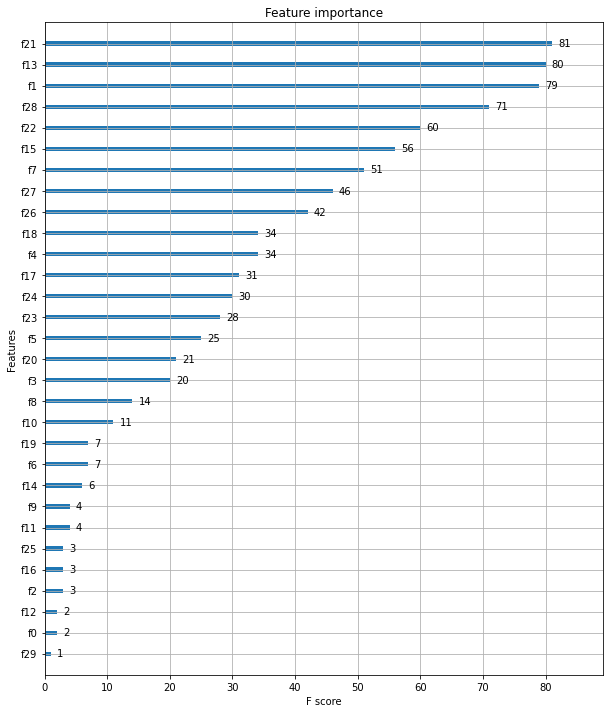

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

# 사이킷런 Wrapper XGBoost 개요 및 적용

In [ ]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [ ]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC: 0.9951


In [ ]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
                eval_set=evals, verbose=True)
# verbose는 학습의 진행 상황을 보여줄 것인지 지정하는 것임.
# verbose=1로 지정하면 학습이 되는 모습을 보이나, 너무 많이 print가 찍히므로 상황에 따라 설정

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

In [ ]:
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC: 0.9954


In [ ]:
# early_stopping_rounds를 10으로 설정 후 재 학습
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10,
                eval_metric="logloss", eval_set=evals, verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


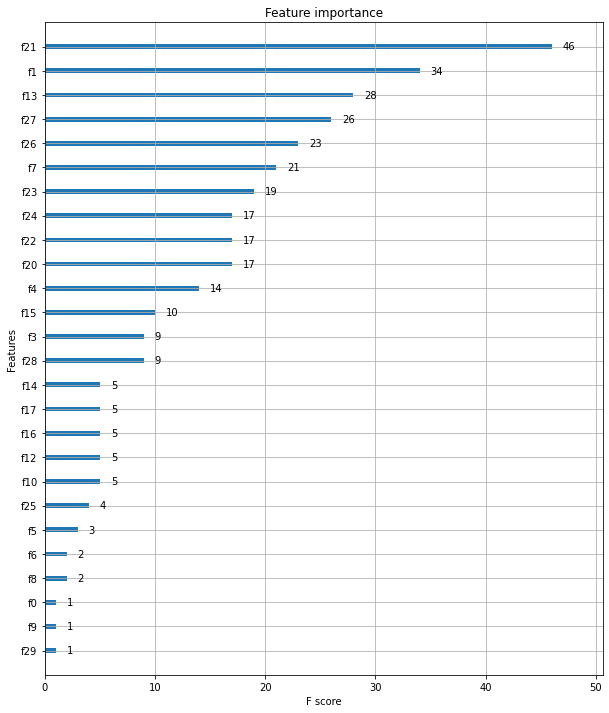

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))

# 사이킷런 래퍼 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)